In [1]:
import numpy as np 
import pandas as pd
from scipy import fft
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt 
from scipy.signal import periodogram
from matplotlib.ticker import FuncFormatter 
from matplotlib.ticker import MultipleLocator
FuncFormatter

matplotlib.ticker.FuncFormatter

In [2]:
# Membaca data
df = pd.read_excel('QBO Data.xlsx')

# Menampilkan DataFrame
print(df)

     30 hPa  25 hPa  20 hPa       Date
0      -260    -289    -326 1987-01-01
1      -266    -280    -307 1987-02-01
2      -271    -309    -311 1987-03-01
3      -270    -303    -328 1987-04-01
4      -268    -289    -295 1987-05-01
..      ...     ...     ...        ...
414    -238    -297    -316 2021-07-01
415    -233    -319    -330 2021-08-01
416    -268    -332    -359 2021-09-01
417    -283    -339    -368 2021-10-01
418    -279    -320    -351 2021-11-01

[419 rows x 4 columns]


In [3]:
# Membaca data
df2 = pd.read_excel('Total Column Ozone.xlsx')

# Menampilkan DataFrame
print(df2)

# Ambil nilai ozon sebagai array
ozon = df2['TCO'].values

          Date  Pressure        O3        TCO
0   1987-01-01        30  0.000006   9.075149
1   1987-02-01        30  0.000006   8.977161
2   1987-03-01        30  0.000007   9.763546
3   1987-04-01        30  0.000007  10.320326
4   1987-05-01        30  0.000007  10.529456
..         ...       ...       ...        ...
415 2021-08-01        30  0.000007   9.762721
416 2021-09-01        30  0.000007   9.810447
417 2021-10-01        30  0.000007   9.827716
418 2021-11-01        30  0.000007   9.796759
419 2021-12-01        30  0.000007   9.733074

[420 rows x 4 columns]


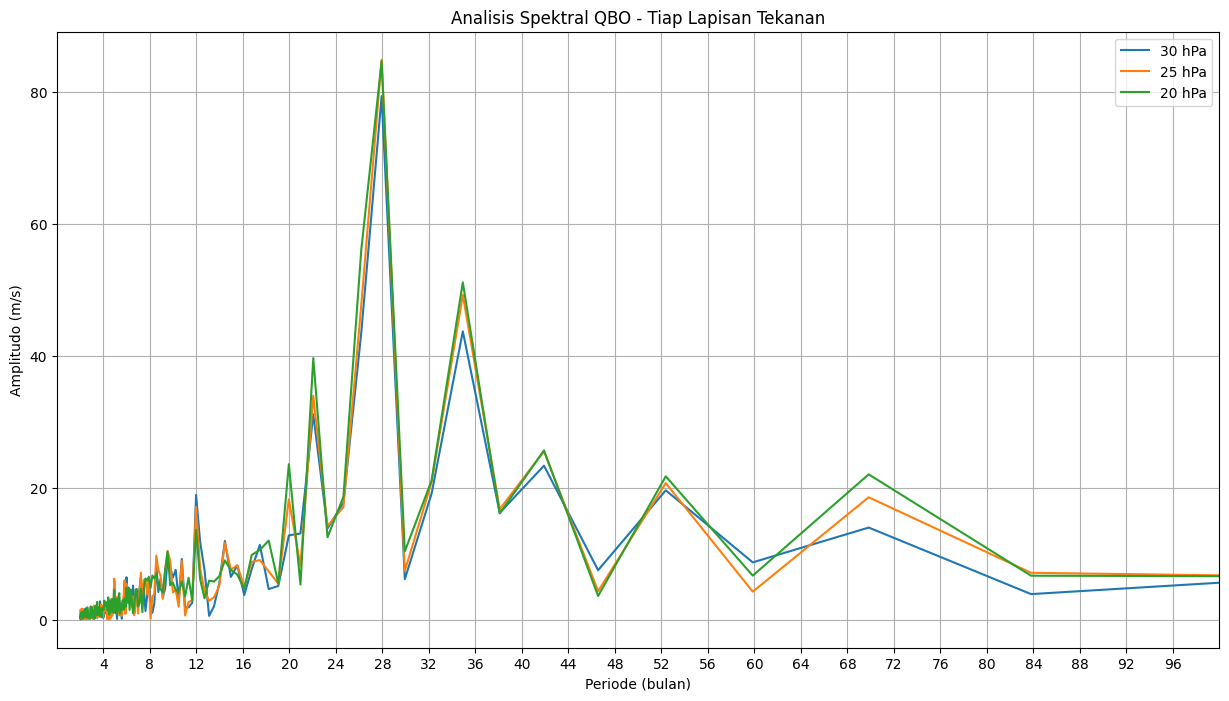


Lapisan dengan komponen spektral paling dominan:
  Lapisan  Amplitudo Dominan  Periode Dominan (bulan)
1  25 hPa          84.914368                27.933333
2  20 hPa          84.687375                27.933333
0  30 hPa          79.403170                27.933333


In [4]:
# 1. Load data
file_path = "QBO Data.xlsx"
df = pd.read_excel(file_path)

# Pastikan kolom 'Date' jadi index waktu
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop kolom Year dan Month jika masih ada
df = df.drop(columns=['Year', 'Month'], errors='ignore')

# 2. Lakukan FFT pada masing-masing lapisan tekanan
plt.figure(figsize=(15, 8))
dominant_amplitudes = {}
dominant_periods = {}

for column in df.columns:
    signal = df[column].dropna()
    n = len(signal)
    timestep = 1  # diasumsikan data bulanan
    freq = fftfreq(n, d=timestep)
    fft_values = fft(signal) / n  # Normalisasi oleh jumlah data
    
    # Ambil hanya frekuensi positif
    positive_freqs = freq[:n // 2]
    magnitude = np.abs(fft_values[:n // 2])  # Ambil frekuensi positif

    # Simpan data spektrum dominan
    max_index = np.argmax(magnitude[1:]) + 1  # skip frekuensi 0
    dominant_freq = positive_freqs[max_index]
    dominant_period = 1 / dominant_freq if dominant_freq != 0 else np.nan
    dominant_amplitudes[column] = magnitude[max_index]
    dominant_periods[column] = dominant_period

    # Plot spektrum
    plt.plot(1 / positive_freqs[1:], magnitude[1:], label=f"{column}")

# Menyesuaikan sumbu periode ke kelipatan 4
plt.xticks(np.arange(4, 100, 4))

plt.xlabel("Periode (bulan)")
plt.ylabel("Amplitudo (m/s)")
plt.title("Analisis Spektral QBO - Tiap Lapisan Tekanan")
plt.legend()
plt.grid(True)
plt.xlim(0, 100)
plt.show()

# 3. Ringkasan hasil dominan
dominant_df = pd.DataFrame({
    "Lapisan": dominant_amplitudes.keys(),
    "Amplitudo Dominan": dominant_amplitudes.values(),
    "Periode Dominan (bulan)": dominant_periods.values()
}).sort_values(by="Amplitudo Dominan", ascending=False)

print("\nLapisan dengan komponen spektral paling dominan:")
print(dominant_df)

Energi Tertinggi (PSD Maks): 35.97917405113608
Frekuensi Dominan: 0.03571428571428572 siklus/bulan
Periode Dominan: 28.00 bulan


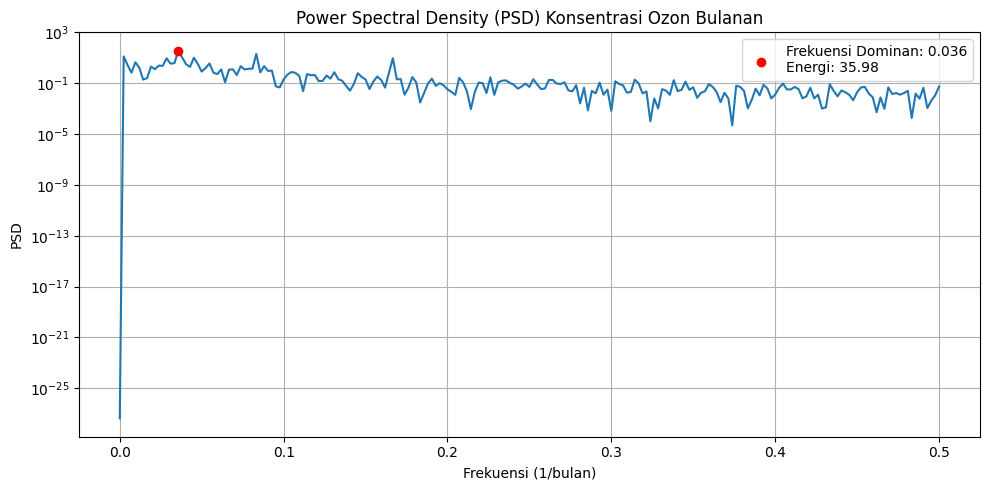

In [5]:
fs = 1  # Sampling 1 per bulan
freqs, psd = periodogram(ozon, fs=fs)

# Temukan energi tertinggi dan frekuensi dominan
idx_max = np.argmax(psd)
energi_tertinggi = psd[idx_max]
frekuensi_dominan = freqs[idx_max]

# Tampilkan hasil
print(f"Energi Tertinggi (PSD Maks): {energi_tertinggi}")
print(f"Frekuensi Dominan: {frekuensi_dominan} siklus/bulan")
if frekuensi_dominan != 0:
    print(f"Periode Dominan: {1/frekuensi_dominan:.2f} bulan")
else:
    print("Periode Dominan: Tak hingga (komponen DC)")

# Visualisasi PSD dan frekuensi dominan
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd)
plt.scatter(
    frekuensi_dominan, energi_tertinggi,
    color='red', zorder=5,
    label=f'Frekuensi Dominan: {frekuensi_dominan:.3f}\nEnergi: {energi_tertinggi:.2f}'
)
plt.title('Power Spectral Density (PSD) Konsentrasi Ozon Bulanan')
plt.xlabel('Frekuensi (1/bulan)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()